In [1]:
import sys
import os
sys.path.append('../dbm_evaluation')
sys.path.append('../DeepView')

from map_evaluation import P_wrapper, Evaluator, NNinv_keras, NNinv_torch, MapBuilder


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
#import knn and decision tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
# import make blobs
from sklearn.datasets import make_blobs
from sklearn.datasets import load_iris

from scipy.spatial import Delaunay
from scipy.interpolate import Rbf

# date
from datetime import datetime

from umap import UMAP

from tqdm import tqdm

from ssnp import SSNP

/home/peyote/.conda/envs/tf3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-21 17:47:47.064054: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-21 17:47:47.088034: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 17:47:47.088056: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 17:47:47

In [2]:
# # import PCA
# from sklearn.decomposition import PCA

# blob = make_blobs(n_samples=1000, n_features=1000, centers=3, cluster_std=1.0, center_box=(-10.0, 10.0), shuffle=True, random_state=1)
# pca = PCA(n_components=2)
# pca.fit(blob[0])
# pca_blob = pca.transform(blob[0])

# plt.scatter(pca_blob[:,0], pca_blob[:,1], c=blob[1], cmap='viridis')

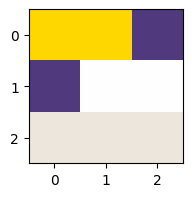

In [10]:
cmap = colors.ListedColormap(['#FED700FF', '#50397DFF', '#FED70001', '#AB8C5A36'])
#  plot the cmap
plt.figure(figsize=(2, 2))
plt.imshow(np.arange(9).reshape((3, 3)), cmap=cmap)

In [3]:
# make my own color map
cmap = colors.ListedColormap(['#3322DD', 'gold' ], name='custom') # '#3322DD' '#EEDD22'
# cmap = 'jet'


(100, 3)

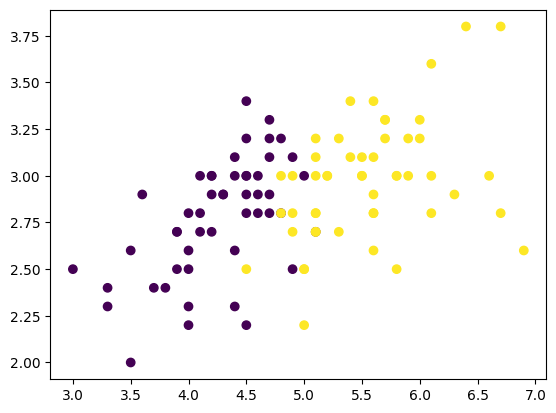

In [4]:
## Load iris data

iris = load_iris()
# ind = y != 0
ind = np.where(iris.target != 0)[0]

X = iris.data[ind, :3]
y = iris.target[ind]
y = y - 1
blob0 = [X, y]
# visualize
plt.scatter(X[:,2], X[:,1], c=y, cmap='viridis')

X.shape

#### blob

# blob0 = make_blobs(n_samples=150, n_features=3, centers=2, cluster_std=3.5, random_state=1)
# # blob0 = make_blobs(n_samples=150, n_features=3, centers=5, cluster_std=1.2, random_state=6666)
# y = blob0[1]

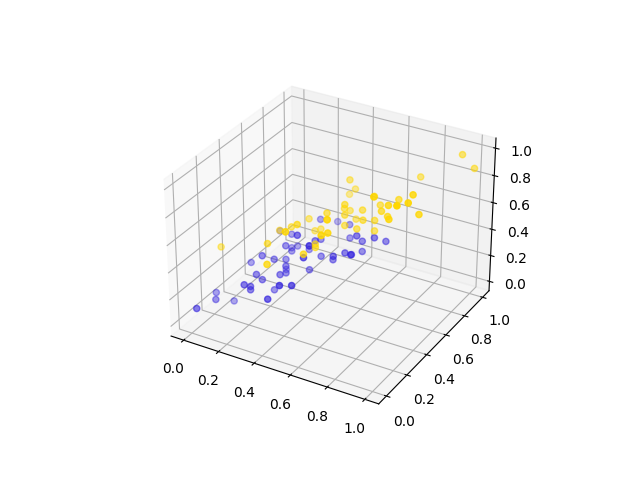

In [5]:
%matplotlib widget

# plot the blobs in 3D"
fig_3d = plt.figure()
ax_3d = fig_3d.add_subplot(111, projection='3d')
# ax.view_init() what is the default view? type help(ax.view_init)
# help(ax.view_init)
CMAP = cmap#"custom" #'PiYG'
pinot_clor_map = cm.get_cmap(CMAP)
ponit_clor = pinot_clor_map(y/y.max())

#####
lazy_scaler = MinMaxScaler()
blob0 = list(blob0)
blob0[0] = lazy_scaler.fit_transform(blob0[0])
#####

ax_3d.scatter(blob0[0][:,0], blob0[0][:,1], blob0[0][:,2], c=ponit_clor, )#cmap='tab10', )

In [6]:
class Simple_P_wrapper:
    def __init__(self, P, Pinv):
        self.P = P
        self.Pinv = Pinv
    def __call__(self, x):
        return self.P(x)
    def transform(self, x):
        return self.P.transform(x)
    def inverse_transform(self, x):
        return self.Pinv.transform(x)

    def fit(self, x, y=None, clf=None):
        self.P.fit(x)
        self.Pinv.fit(self.P.transform(x), x )
        return self

p = UMAP(n_components=2, random_state=43, n_neighbors=30, min_dist=0.9)
Pinv = NNinv_torch(dims=[2048]*4)
proj = Simple_P_wrapper(p, Pinv)

device:  cuda:0


In [7]:
scaler = MinMaxScaler()
X = scaler.fit_transform(blob0[0])
# X = blob0[0]
y = blob0[1]

NNinv_keras = 0
NNinv_torch = 1
deepview = 0
ssnp = 0

name_list = ['NNinv_keras', 'NNinv_torch', 'deepview', 'ssnp']
#get the none zero name
name_plot = [name_list[i] for i in [NNinv_keras, NNinv_torch, deepview, ssnp] if i != 0][0]

# ssnp = SSNP(patience=5, opt='adam', bottleneck_activation='linear', verbose=0)
proj = P_wrapper(NNinv_Keras=NNinv_keras, NNinv_Torch=NNinv_torch, deepview=deepview, ssnp=ssnp)
clf = linear_model.LogisticRegression()
clf = SVC(probability=True)
clf = KNeighborsClassifier()
clf = DecisionTreeClassifier()
# clf = RandomForestClassifier()
dbm = P_wrapper(NNinv_Torch=1, deepview=0, ssnp=0, NNinv_Keras=0)
ssnp = P_wrapper(NNinv_Keras=0, NNinv_Torch=0, deepview=0, ssnp=1)
DV = P_wrapper(NNinv_Keras=0, NNinv_Torch=0, deepview=1, ssnp=0)


clf.fit(X, y)

DV.fit(X, y, clf, lam=0.65)
dbm.fit(X, y, clf)
ssnp.fit(X, y, clf)


100%|██████████| 100/100 [00:00<00:00, 1911.08it/s]

updating matrices
(0,) (100, 100)
discr 0.00019788742065429688
(0,) (100, 100)
fitting mapper


transforming
fitting inverse


/home/peyote/miniconda3/envs/tf3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


done
fitting time:  4.779814004898071
device:  cuda:0
Early stopping at epoch 130
fitting time:  2.670384168624878
device:  /device:GPU:0


2023-10-02 22:28:44.182643: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-02 22:28:44.183836: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-02 22:28:44.189402: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-02 22:28:44.189609: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

fitting time:  2.4750378131866455


2.4750378131866455

In [8]:
# import tensorflow as tf
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# if len(physical_devices) > 0:
#     tf.config.experimental.set_memory_growth(physical_devices[0], True)


# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# ! pip list | grep tensor

calculating probability map
(10404, 3)


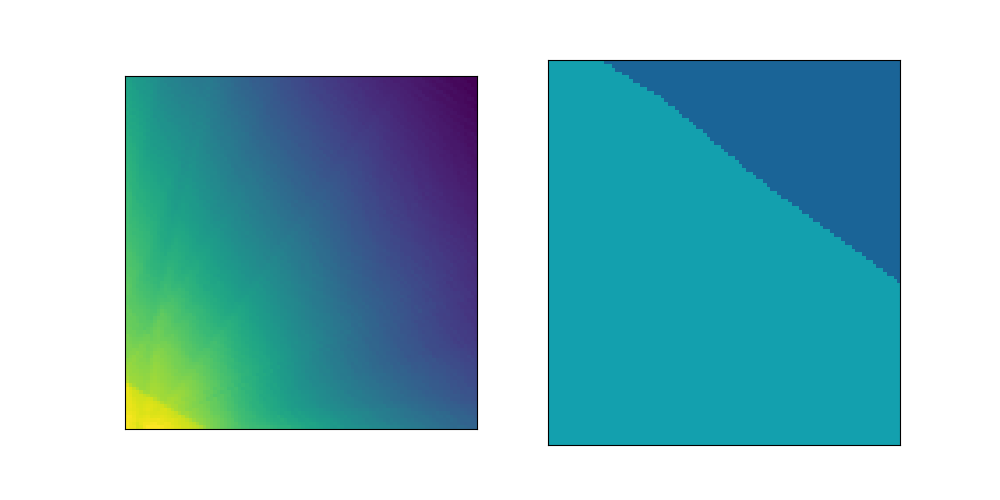

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
map_builder = MapBuilder(clf, ssnp, X, y, grid=100)
ax_grad = map_builder.plot_gradient_map(ax=ax1)
dv_map = map_builder.plot_prob_map(ax=ax2)
plt.show()

[]

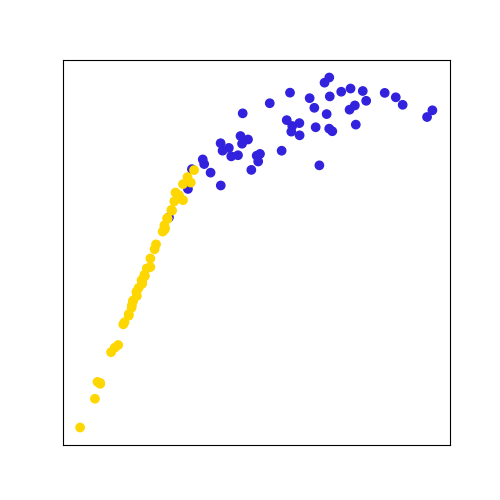

In [10]:
X_2d = ssnp.transform(blob0[0])
# scale the data to be between 0 and 1
# scaler2d = MinMaxScaler()
# X_2d = scaler2d.fit_transform(X_2d)


fig, ax = plt.subplots(figsize=(5,5) )
ax.scatter(X_2d[:,0], X_2d[:,1], c=ponit_clor)
# no ticks
ax.set_xticks([])
ax.set_yticks([])
# suqare aspect ratio`
# ax.set_aspect('equal')
# make directory if it doesn't exist
# if not os.path.exists('./figures/inlustrate_dbm'):
#     os.makedirs('./figures/inlustrate_dbm')
# fig.savefig('./figures/inlustrate_dbm/2d_1')

In [11]:
# %matplotlib widget
GRID = 20
# CMAP = 'tab10'


In [12]:
def plot_inverse_map(P_inv, GRID=GRID, clf=clf, ax=None, CMAP=CMAP, single_color=False):

    

    
    X_2d = P_inv.transform(blob0[0])


    xx, yy = np.meshgrid(np.linspace(X_2d[:,0].min(), X_2d[:,0].max(), GRID), np.linspace(X_2d[:,1].min(), X_2d[:,1].max(), GRID))
    XY = np.c_[xx.ravel(), yy.ravel()]
    XY_3d = P_inv.inverse_transform(XY)
    XY_3d = scaler.inverse_transform(XY_3d)
    labels = clf.predict(XY_3d)
    ## grids with labels
    tab10 = cm.get_cmap(CMAP)
    labels_color = tab10(labels/labels.max())
    labels_color_2d = tab10(labels.reshape(GRID,GRID)/labels.max())
    # set alpha to 0.5
    labels_color_2d[:, : ,3] = 0.7
    # print(labels_color_2d.shape)
    # print(XY_3d[:,0].reshape(GRID,GRID).shape)
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

    # visual_scaler = MinMaxScaler(0, GRID)

    # # ax_grid_dbm.scatter(XY_3d[:,0], XY_3d[:,1], XY_3d[:,2], c=labels_color[:], alpha=0.9, marker='+', cmap = 'tab10', s=100)
    # ax.scatter(blob0[0][:,0], blob0[0][:,1], blob0[0][:,2], c=blob0[1], cmap='tab10', ec='k', s=7, linewidth=0.1, alpha=0.75)

    # # ax_grid_dbm.plot_wireframe(XY_3d[:,0].reshape(GRID,GRID), XY_3d[:,1].reshape(GRID,GRID), XY_3d[:,2].reshape(GRID,GRID), colors=labels_color, alpha=0.5,)
    # ax.plot_surface(
    #     XY_3d[:,0].reshape(GRID,GRID), XY_3d[:,1].reshape(GRID,GRID), XY_3d[:,2].reshape(GRID,GRID), facecolors=labels_color_2d, #shade=False, #alpha=0.5, 
    #       linewidth=0.0, antialiased=False, rstride=1, cstride=1, )
    
    ########################### volume version plot##########
        # ax_grid_dbm.scatter(XY_3d[:,0], XY_3d[:,1], XY_3d[:,2], c=labels_color[:], alpha=0.9, marker='+', cmap = 'tab10', s=100)
    scatter2plot = blob0[0] * GRID
    ax.scatter(scatter2plot[:,0], scatter2plot[:,1], scatter2plot[:,2], c=blob0[1], cmap=CMAP, ec='k', s=7, linewidth=0.15, alpha=0.75)

    XY_3d *= GRID

    if not single_color:
        ax.plot_surface(
            XY_3d[:,0].reshape(GRID,GRID), XY_3d[:,1].reshape(GRID,GRID), XY_3d[:,2].reshape(GRID,GRID), facecolors=labels_color_2d, #shade=False, #alpha=0.5, 
            linewidth=0.0, antialiased=False, rstride=1, cstride=1, )
    else:
        # single color
        single_clor = (0.8, 0.8, 0.8, 0.8)
        single_cloer_2d = np.ones((GRID, GRID, 4))
        single_cloer_2d[:, :, 0] = single_clor[0]
        single_cloer_2d[:, :, 1] = single_clor[1]
        single_cloer_2d[:, :, 2] = single_clor[2]
        single_cloer_2d[:, :, 3] = single_clor[3]

        ax.plot_surface(
            XY_3d[:,0].reshape(GRID,GRID), XY_3d[:,1].reshape(GRID,GRID), XY_3d[:,2].reshape(GRID,GRID), facecolors=single_cloer_2d, ec=None, #shade=False, #alpha=0.5, 
              linewidth=0.0, antialiased=False, rstride=1, cstride=1, )
    
    ######################

    # ratio = 0.1
    # ax.set_xlim(blob0[0][:,0].min()+ratio, blob0[0][:,0].max()*.9)
    # ax.set_ylim(blob0[0][:,1].min()+ratio, blob0[0][:,1].max()*.9)
    # ax.set_zlim(blob0[0][:,2].min()+ratio, blob0[0][:,2].max()*.9)


    return ax, XY_3d

def adjust_ax(ax):
    # # Make panes transparent
    # ax.xaxis.pane.fill = False # Left pane
    # ax.yaxis.pane.fill = False # Right pane
    # ax.zaxis.pane.fill = False # Right pane

    ### Remove grid lines
    # ax.grid(False)

    ## Remove tick labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    # ## Transparent spines
    # ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    # ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    # ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

    # ## Transparent panes
    # ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    ## No ticks
    # ax.set_xticks([]) 
    # ax.set_yticks([]) 
    # ax.set_zticks([])

    # backgroud color
    ax.set_facecolor((0.95, 0.95, 0.95, 0.0))
    return ax

# plot_inverse_map(dbm)
# plt.show()


def empty_ax(ax):
        # Make panes transparent
    ax.xaxis.pane.fill = False # Left pane
    ax.yaxis.pane.fill = False # Right pane
    ax.zaxis.pane.fill = False # Right pane

    ## Remove grid lines
    ax.grid(False)

    ## Remove tick labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    ## Transparent spines
    ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

    ## Transparent panes
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    # No ticks
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    ax.set_zticks([])

In [27]:
from skimage.measure import marching_cubes

def plot_volume2(clf, ax=None, grid=GRID, CMAP=CMAP, scatter=False, voxel=True, d_surface=False):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

    xx, yy, zz = np.meshgrid(np.linspace(blob0[0][:,0].min(), blob0[0][:,0].max(), grid),
                                np.linspace(blob0[0][:,1].min(), blob0[0][:,1].max(), grid),
                                np.linspace(blob0[0][:,2].min(), blob0[0][:,2].max(), grid))
    
    XYZ = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
    labels = clf.predict(XYZ)
    label_cube = labels.reshape(grid, grid, grid)

    # swap axis 
    label_cube = np.swapaxes(label_cube, 0, 1)
    

    cmap = cm.get_cmap(CMAP)
    labels_color_3d = cmap(label_cube/label_cube.max())
    # labels_color_3d = labels_color.reshape(grid, grid, grid, 4)
    labels_color_3d[:, :, :, 3] = 0.4
    voxels = np.ones((grid, grid, grid), dtype=bool)
    if voxel:
        ax.voxels(voxels, facecolors=labels_color_3d, linewidth=0.1, alpha=0.3, shade=False) #edgecolor='k', 

    # Use marching cubes to obtain the surface mesh
    verts, faces, normals, values = marching_cubes(label_cube, level=0.5)

    if d_surface:
        # Plotting the surface
        ax.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], triangles=faces, alpha=0.25, antialiased=True, color='#3322DD', edgecolor=None)

    if scatter:
        scatter2plot = blob0[0] * GRID
        ax.scatter(scatter2plot[:,0], scatter2plot[:,1], scatter2plot[:,2], c=blob0[1], cmap=CMAP, ec='k', s=7, linewidth=0.15, alpha=0.95)

    return ax, verts


def find_intersection(verts, XY_3d, tolerance=0.1):
    intersection_points = []
    for vertex in verts:
        distances = np.linalg.norm(XY_3d - vertex, axis=1)
        if np.any(distances < tolerance):
            intersection_points.append(vertex)
    return np.array(intersection_points)

In [33]:
%matplotlib widget

(9, 3)


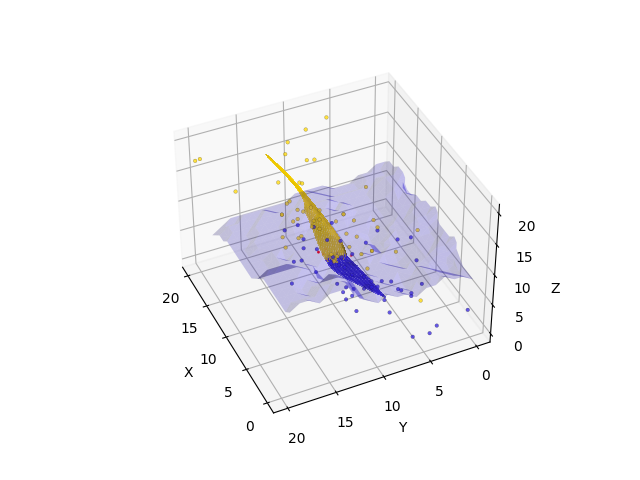

In [34]:
%matplotlib widget
GRID=20
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax, verts  = plot_volume2(clf, ax=ax, grid=GRID, CMAP=CMAP, d_surface=True, voxel=False )
ax, DM_3d = plot_inverse_map(ssnp, GRID=GRID, clf=clf, ax=ax, CMAP=CMAP, single_color=False)

# # Find intersection points
intersection_points = find_intersection(verts, DM_3d, tolerance=0.8)
print(intersection_points.shape)
# # Plot the intersection points
ax.scatter(intersection_points[:, 0], intersection_points[:, 1], intersection_points[:, 2], c='r', s=5, label='Intersection', marker='.')

# # set camera position
# ax.view_init(25, 144)
# # ax.view_init(30, 30)

# set axis label
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(40, 155)

100%|██████████| 100/100 [00:00<00:00, 1700.89it/s]


Text(0.5, 0.92, 'DeepView')

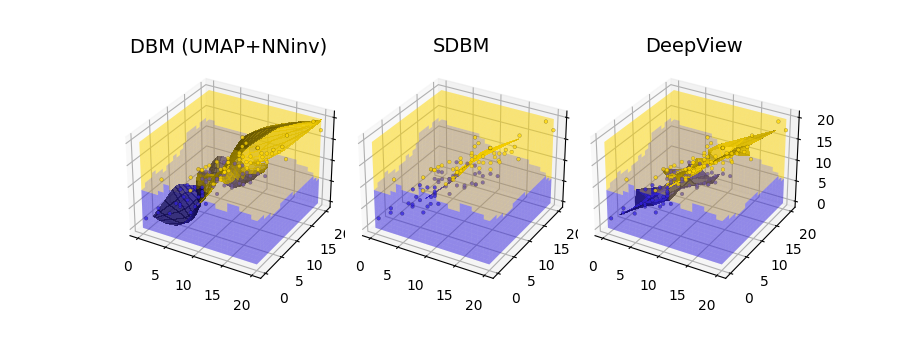

In [30]:
# build a fig with 3 3d-axes
fig = plt.figure(figsize=(9,3.5))
ax1 = fig.add_subplot(131, projection='3d', )
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')
# white space between subplots
fig.subplots_adjust(wspace=0.0, hspace=0.0)

plot_inverse_map(dbm, ax=ax1)
plot_inverse_map(ssnp, ax=ax2)
plot_inverse_map(DV, ax=ax3)

# plot the volume
plot_volume2(clf, ax=ax1)
plot_volume2(clf, ax=ax2)
plot_volume2(clf, ax=ax3)



## set view angle
# viual_angle = (44, -44, 20)
# ax1.view_init(*viual_angle)
# ax2.view_init(*viual_angle)
# ax3.view_init(*viual_angle)

ax1.set_title('DBM (UMAP+NNinv)', fontsize=14)
ax2.set_title('SDBM', fontsize=14)
ax3.set_title('DeepView', fontsize=14)

# fig.savefig('./figures/3d_all.pdf', dpi=300, bbox_inches='tight')
# fig.savefig('../DecisionMap_Comapre_manuscript/figures/demo3d_new.pdf', dpi=300, bbox_inches='tight')

In [31]:
%matplotlib inline
classifiers = {
    'placeholder_clf': linear_model.LogisticRegression(),
    'Logistic Regression': linear_model.LogisticRegression(),
    'SVM': SVC(probability=True),
    'Random Forest': RandomForestClassifier(),
    'Neural Network': MLPClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(),
}

## fit the models
for name, clf in classifiers.items():
    clf.fit(X, y)
    
dms = {
    'placeholder': P_wrapper(),
    'DBM': dbm,
    'SDBM': ssnp,
    'DeepView': DV,
}



/home/peyote/miniconda3/envs/tf3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


100%|██████████| 100/100 [00:00<00:00, 2502.18it/s]


updating matrices
(0,) (100, 100)
discr 0.00025963783264160156
(0,) (100, 100)
fitting mapper


/home/peyote/miniconda3/envs/tf3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


transforming
fitting inverse
done
fitting time:  0.633225679397583


100%|██████████| 100/100 [00:00<00:00, 889.01it/s]


updating matrices
(0,) (100, 100)
discr 0.0002148151397705078
(0,) (100, 100)
fitting mapper


/home/peyote/miniconda3/envs/tf3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


transforming
fitting inverse
done
fitting time:  0.6850428581237793


100%|██████████| 100/100 [00:00<00:00, 132.41it/s]


updating matrices
(0,) (100, 100)
discr 0.00022268295288085938
(0,) (100, 100)
fitting mapper


/home/peyote/miniconda3/envs/tf3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


transforming
fitting inverse
done
fitting time:  1.3672080039978027


100%|██████████| 100/100 [00:00<00:00, 530.43it/s]


updating matrices
(0,) (100, 100)
discr 7.510185241699219e-05
(0,) (100, 100)
fitting mapper


/home/peyote/miniconda3/envs/tf3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


transforming
fitting inverse
done
fitting time:  0.7872533798217773


100%|██████████| 100/100 [00:00<00:00, 2284.01it/s]


updating matrices
(0,) (100, 100)
discr 0.00018858909606933594
(0,) (100, 100)
fitting mapper


/home/peyote/miniconda3/envs/tf3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


transforming
fitting inverse
done
fitting time:  0.5944674015045166


100%|██████████| 100/100 [00:00<00:00, 795.58it/s]


updating matrices
(0,) (100, 100)
discr 0.0002117156982421875
(0,) (100, 100)
fitting mapper


/home/peyote/miniconda3/envs/tf3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


transforming
fitting inverse
done
fitting time:  0.7153322696685791


100%|██████████| 100/100 [00:00<00:00, 529.99it/s]


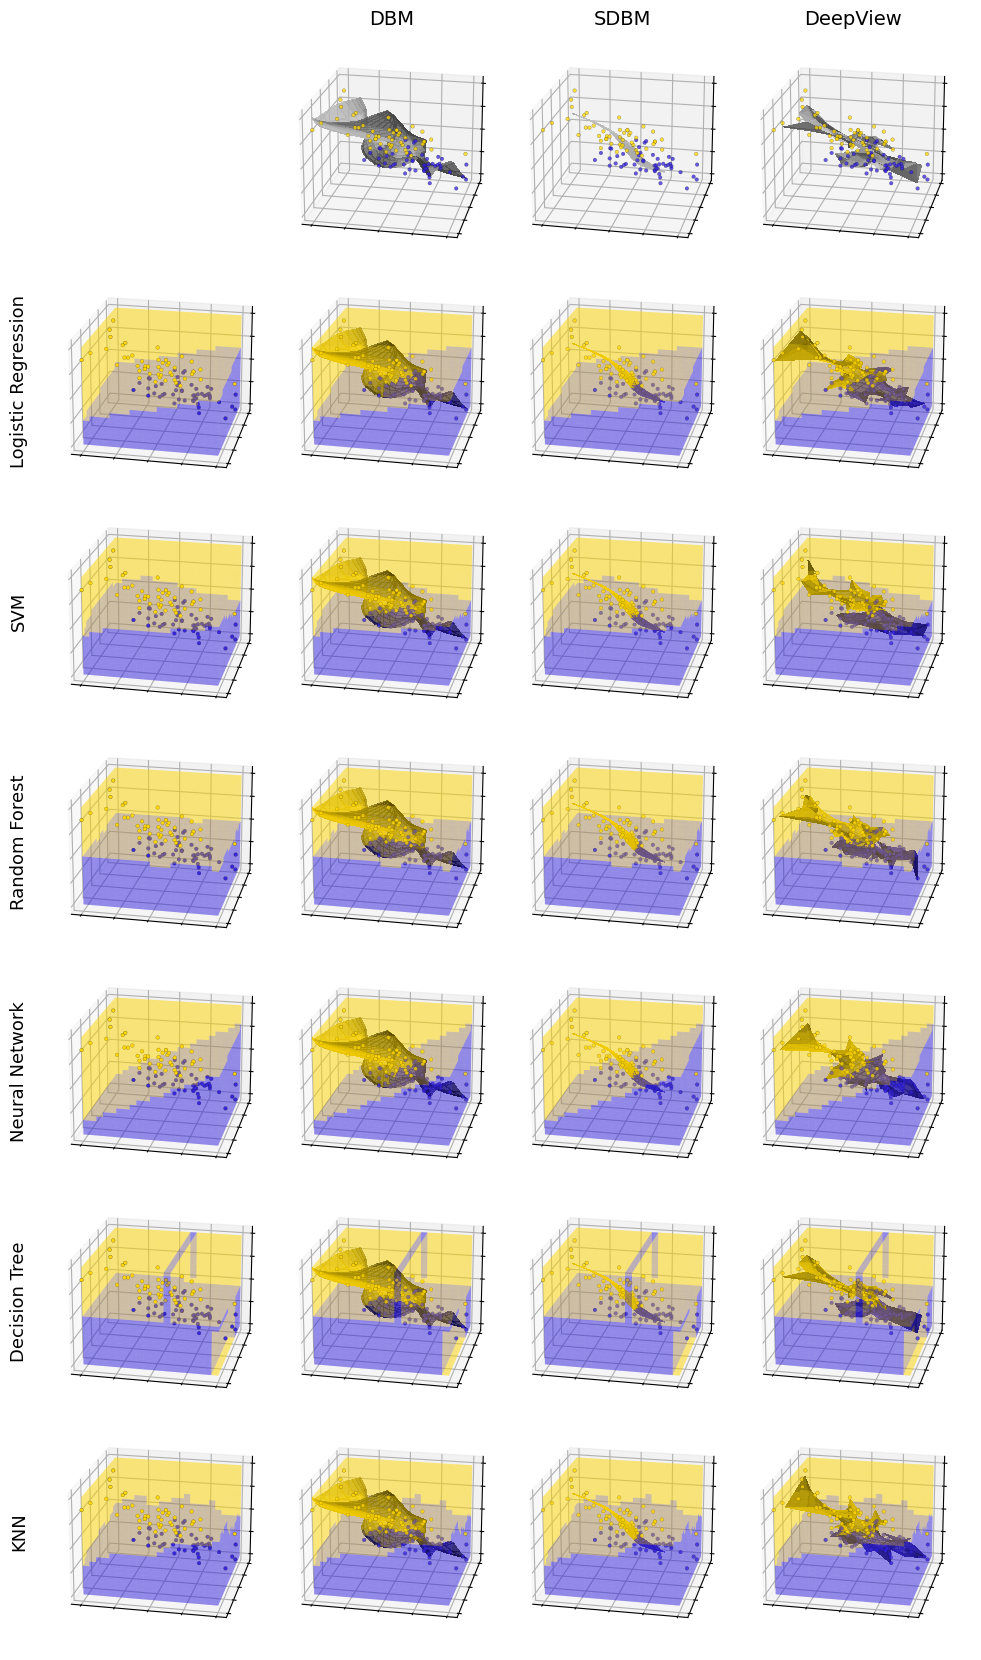

In [32]:
## plot the figur, cols is number of dms+1, rows is number of classifiers+1
GRID = 20
d_surface = False

cols = len(dms) 
rows = len(classifiers) 

fig3d = plt.figure(figsize=(cols*3, rows*3))
fig3d.subplots_adjust(wspace=-0.03, hspace=-0.03)

for i, (clf_name, clf) in enumerate(classifiers.items()):
    for j, (dm_name, dm) in enumerate(dms.items()):
        # print(i, j)
        ax = fig3d.add_subplot(rows, cols, i*cols+j+1, projection='3d')
        adjust_ax(ax)
        if i == 0 and j == 0:
            ### show nothing, leave it blank
            ax.set_axis_off()
            continue
        if i == 0:
            # 3d plot
            
            plot_inverse_map(dm, ax=ax, clf=clf, single_color=True, GRID=GRID)
            ax.set_title(dm_name, fontsize=14)

        elif j == 0:
            plot_volume2(clf, ax=ax, grid=GRID, CMAP=CMAP, scatter=True, voxel=True, d_surface=d_surface)
            # a label at the left of each row
            ax.text2D(-0.1, 0.5, clf_name, fontsize=13, transform=ax.transAxes, rotation=90, va='center', ha='center')
        else:
            if dm_name == 'DeepView':
                dm = P_wrapper(NNinv_Keras=0, NNinv_Torch=0, deepview=1, ssnp=0)
                dm.fit(X, y, clf)
            plot_inverse_map(P_inv=dm, ax=ax, clf=clf, single_color=False, GRID=GRID)
            plot_volume2(clf, ax=ax, grid=GRID, CMAP=CMAP, scatter=False, voxel=True, d_surface=d_surface)

        adjust_ax(ax)
        # ax.view_init(25, 144)
        # ax.view_init(35, 35)
        # ax.view_init(7, 35)
        ax.view_init(40, 155)
        ax.view_init(20, 102)
# fig.savefig('./figures/3d_all.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [19]:
# fig3d.savefig('../paper/PAPER_intrinsic_dim/figures/dm3d_all.png', dpi=300, bbox_inches='tight')
# fig3d.savefig('../paper/PAPER_intrinsic_dim/figures/dm3d_all_iris.png', dpi=300, bbox_inches='tight')

In [20]:
# # swap axis 0 and 1 in figure 3d

# fig3d = plt.figure(figsize=(cols*3, rows*3))
# fig3d.subplots_adjust(wspace=0.0, hspace=0.0)

# for i, (clf_name, clf) in enumerate(classifiers.items()):
#     for j, (dm_name, dm) in enumerate(dms.items()):
#         # print(i, j)
#         ax = fig.add_subplot(rows, cols, i*cols+j+1, projection='3d')
#         adjust_ax(ax)
#         if i == 0 and j == 0:
#             continue
#         if i == 0:
#             # 3d plot
            
#             plot_inverse_map(dm, ax=ax, clf=clf, single_color=True, GRID=GRID)
#             ax.set_title(dm_name, fontsize=14)

#         elif j == 0:
#             plot_volume2(clf, ax=ax, grid=GRID, CMAP=CMAP, scatter=True, voxel=True, d_surface=False)
#             # a label at the left of each row
#             ax.text2D(-0.1, 0.5, clf_name, fontsize=13, transform=ax.transAxes, rotation=90, va='center', ha='center')
#         else:
#             plot_inverse_map(dm, ax=ax, clf=clf, single_color=False, GRID=GRID)
#             plot_volume2(clf, ax=ax, grid=GRID, CMAP=CMAP, scatter=False, voxel=True, d_surface=False)

#         adjust_ax(ax)
#         # ax.view_init(25, 144)
#         # ax.view_init(35, 35)
# # fig.savefig('./figures/dm3d_all_horizontal.png', dpi=300, bbox_inches='tight')

calculating probability map
calculating probability map


100%|██████████| 100/100 [00:00<00:00, 1125.75it/s]


updating matrices
(0,) (100, 100)
discr 0.0005154609680175781
(0,) (100, 100)
fitting mapper
transforming
fitting inverse
done
fitting time:  0.7220938205718994
calculating probability map


/home/peyote/miniconda3/envs/tf3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


calculating probability map
calculating probability map


100%|██████████| 100/100 [00:00<00:00, 876.23it/s]


updating matrices
(0,) (100, 100)
discr 6.508827209472656e-05
(0,) (100, 100)
fitting mapper
transforming
fitting inverse
done
fitting time:  0.8015236854553223
calculating probability map


/home/peyote/miniconda3/envs/tf3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


calculating probability map
calculating probability map


100%|██████████| 100/100 [00:00<00:00, 147.04it/s]


updating matrices
(0,) (100, 100)
discr 0.0004367828369140625
(0,) (100, 100)
fitting mapper
transforming
fitting inverse
done
fitting time:  2.0656490325927734
calculating probability map


/home/peyote/miniconda3/envs/tf3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


calculating probability map
calculating probability map


100%|██████████| 100/100 [00:00<00:00, 326.63it/s]


updating matrices
(0,) (100, 100)
discr 0.0001323223114013672
(0,) (100, 100)
fitting mapper
transforming
fitting inverse
done
fitting time:  0.9467751979827881
calculating probability map


/home/peyote/miniconda3/envs/tf3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


calculating probability map
calculating probability map


100%|██████████| 100/100 [00:00<00:00, 2225.26it/s]


updating matrices
(0,) (100, 100)
discr 0.00021409988403320312
(0,) (100, 100)
fitting mapper
transforming
fitting inverse
done
fitting time:  0.6991937160491943
calculating probability map


/home/peyote/miniconda3/envs/tf3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


calculating probability map
calculating probability map


100%|██████████| 100/100 [00:00<00:00, 841.06it/s]


updating matrices
(0,) (100, 100)
discr 0.0003108978271484375
(0,) (100, 100)
fitting mapper
transforming
fitting inverse
done
fitting time:  0.7092175483703613
calculating probability map


/home/peyote/miniconda3/envs/tf3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


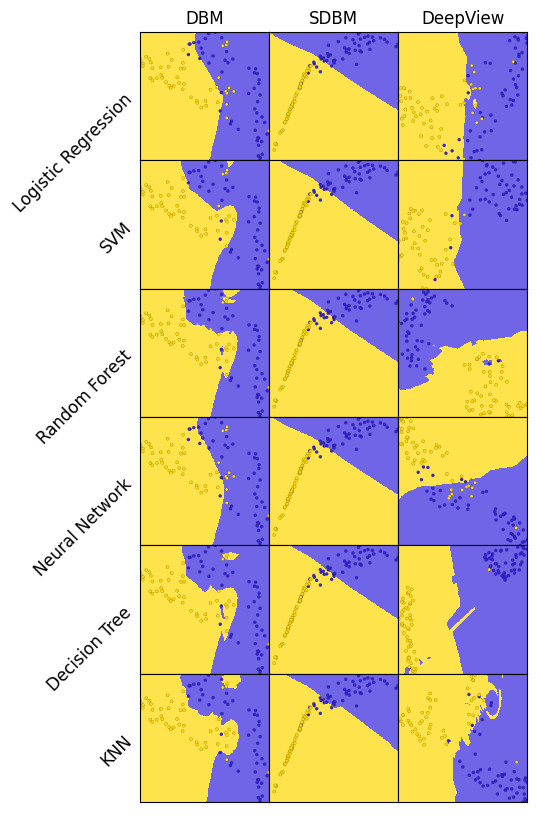

In [21]:
## 

fig, axes = plt.subplots(rows-1, cols-1, figsize=(5, 10))
fig.subplots_adjust(wspace=0.0, hspace=0.0)

for i, (clf_name, clf) in enumerate(classifiers.items()):
    for j, (dm_name, dm) in enumerate(dms.items()):
        if i == 0 or j == 0:
            continue
        ax = axes[i-1, j-1]
        # sqaure aspect ratio
        ax.set_aspect('equal')
        # legend false
        if dm_name == 'DeepView':
                dm = P_wrapper(NNinv_Keras=0, NNinv_Torch=0, deepview=1, ssnp=0)
                dm.fit(X, y, clf)
        dm_holder = MapBuilder(clf, dm, X, y, grid=300) ## it was 300
        ax = dm_holder.plot_prob_map(ax=ax, proba=False, cmap=CMAP, epsilo=0.7)
        dm_holder.plot_training_data(ax=ax, cmap=CMAP, ec='k', lw=0.1, size=20)
        ax.legend_ = None
        if i == 1:
            ax.set_title(dm_name, fontsize=12)
        if j == 1:
            ax.set_ylabel(clf_name, fontsize=12, rotation=45, ha='right', va='center')
# plt.tight_layout()

In [22]:
# fig.savefig('../paper/PAPER_intrinsic_dim/figures/dm2d_all.png', dpi=300, bbox_inches='tight')
# fig.savefig('../paper/PAPER_intrinsic_dim/figures/dm2d_all_iris.png', dpi=300, bbox_inches='tight')